In [1]:
import requests
import json
import pandas as pd
import datetime
import math


# Examining the Sample Data

In [2]:
sample_data = pd.read_excel("sample_data_exl.xlsx", "comment data")

In [3]:
sample_data.shape

(558, 19)

In [4]:
sample_data.head(3)

,index,approved,avatar,children,content,deleted,depth,downVotes,edited,flair,id,joinDate,poster,posterId,timeCommented,upVotes,vip,chID,chNumber
0,0,False,/avatars/Tsuna.png?ver=5421e7a9deb700ecea8931d...,[],Eh I planned to have the first this time! \r\n...,False,1,0,False,NaN,388011,1.466432e+09,Tsuna,6496bc35-b714-4708-945f-a65bab6c98ff,1.481379e+09,3,False,11983,1
1,1,False,https://cdn.wuxiaworld.com/avatars/zaltrhiz.pn...,[],A Splendid Translation of A Will Eternal Chapt...,False,1,0,False,NaN,388066,1.441135e+09,zaltrhiz,30d5304d-1fb7-46c4-b310-e285d11846b9,1.481383e+09,3,False,11983,1
2,2,False,/images/profile.png,[],"i'm currently studying chinese at university, ...",False,1,0,False,NaN,388060,1.450801e+09,miticogiorgio,339c502b-3863-4058-a055-a95ab768383c,1.481382e+09,2,False,11983,1


# Cleaning the Data

In [5]:
def cleanComments(comments):
    # cleans data inplace
    
    # Converting from unix time stamp to regular date time and date.
    comments['timeCommented'] = pd.to_datetime(comments['timeCommented'],unit='s')
    comments['dateCommented'] = comments['timeCommented'].apply(lambda x: datetime.datetime.date(x))
    comments['joinDate'] = pd.to_datetime(comments['joinDate'],unit='s')
    
    del comments['index'] # redundant index column which was associated with comment number for a specific chapter.
    del comments['avatar']  # User avatar image is not related to goal of sentimentality analysis and image analysis is outside the scope of the project's goal.
    del comments['approved'] # All rows are true. Useless feature.
    del comments['deleted']  # All rows are false. Useless feature.
    del comments['children'] # Child comments are swayed by other comments, so they add unessary complexity to the analysis.
    del comments['depth']    # Depth is irrelevant since all commments are top level now.
    del comments['edited']   # Whether a comment has been edited or not is irrelevant due to how the comment editing system works.
    del comments['flair']    # too few users have flairs for this feature to be signifigant as of now. It's an interesting feature to look at once user flair functionality is expanded.
    # By ignoring child comments, each comment is more more like a review. 

In [6]:
cleanComments(sample_data)

In [7]:
sample_data.head(3)

,content,downVotes,id,joinDate,poster,posterId,timeCommented,upVotes,vip,chID,chNumber,dateCommented
0,Eh I planned to have the first this time! \r\n...,0,388011,2016-06-20 14:11:41,Tsuna,6496bc35-b714-4708-945f-a65bab6c98ff,2016-12-10 14:05:01,3,False,11983,1,2016-12-10
1,A Splendid Translation of A Will Eternal Chapt...,0,388066,2015-09-01 19:22:04,zaltrhiz,30d5304d-1fb7-46c4-b310-e285d11846b9,2016-12-10 15:12:23,3,False,11983,1,2016-12-10
2,"i'm currently studying chinese at university, ...",0,388060,2015-12-22 16:19:58,miticogiorgio,339c502b-3863-4058-a055-a95ab768383c,2016-12-10 15:05:42,2,False,11983,1,2016-12-10


# Sentiment Analysis using Vader

In [8]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

In [9]:
def sentimentScore(sentence):
    snt = analyser.polarity_scores(sentence)
    return snt['compound']

In [10]:
def calcSentScores(data):
    data['sentiment'] = data['content'].apply(sentimentScore)

In [11]:
def sentimentStats(data):
    print(data['sentiment'].describe())

In [12]:
def chSentScores(data):
    return data.groupby(['chNumber']).mean()

In [13]:
def dateSentScores(data):
    return data.groupby(['dateCommented']).mean()

In [14]:
def userSentScores(data):
    return data.groupby(['posterId'])[['posterId','sentiment']].mean()

In [15]:
calcSentScores(sample_data)

In [16]:
sample_data.head(3)

,content,downVotes,id,joinDate,poster,posterId,timeCommented,upVotes,vip,chID,chNumber,dateCommented,sentiment
0,Eh I planned to have the first this time! \r\n...,0,388011,2016-06-20 14:11:41,Tsuna,6496bc35-b714-4708-945f-a65bab6c98ff,2016-12-10 14:05:01,3,False,11983,1,2016-12-10,0.6114
1,A Splendid Translation of A Will Eternal Chapt...,0,388066,2015-09-01 19:22:04,zaltrhiz,30d5304d-1fb7-46c4-b310-e285d11846b9,2016-12-10 15:12:23,3,False,11983,1,2016-12-10,0.8225
2,"i'm currently studying chinese at university, ...",0,388060,2015-12-22 16:19:58,miticogiorgio,339c502b-3863-4058-a055-a95ab768383c,2016-12-10 15:05:42,2,False,11983,1,2016-12-10,0.0000


## Visualizing Sentiment Scores by Chapter, Date, and User

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

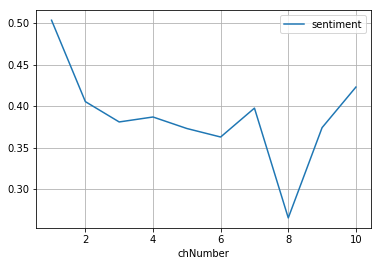

In [18]:
chSent = chSentScores(sample_data)
chSent.reset_index(inplace=True)
chSent.plot(x='chNumber', y='sentiment', kind='line', grid='True')

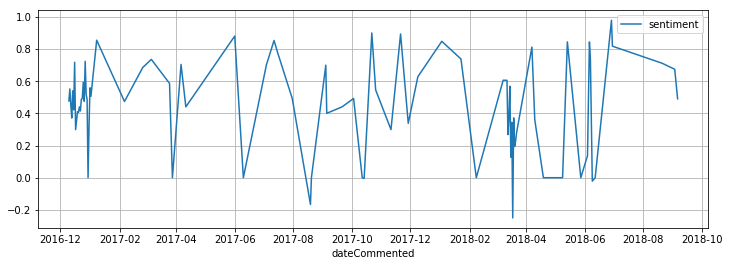

In [19]:
dateSent = dateSentScores(sample_data)
dateSent.reset_index(inplace=True)
dateSent.plot(x='dateCommented', y='sentiment', kind='line', figsize=(12,4), grid=True)

The sample data is mainly from the beginning of the novel's publishing, which is concentrated in 2016-12/2017-01. The irregularity of the rest of the data is due to a slow trickle of new users commenting after the initial wave of readers when a new chapter is published. Grabbing data from all of the released chapters would make the graph less abnormal. 

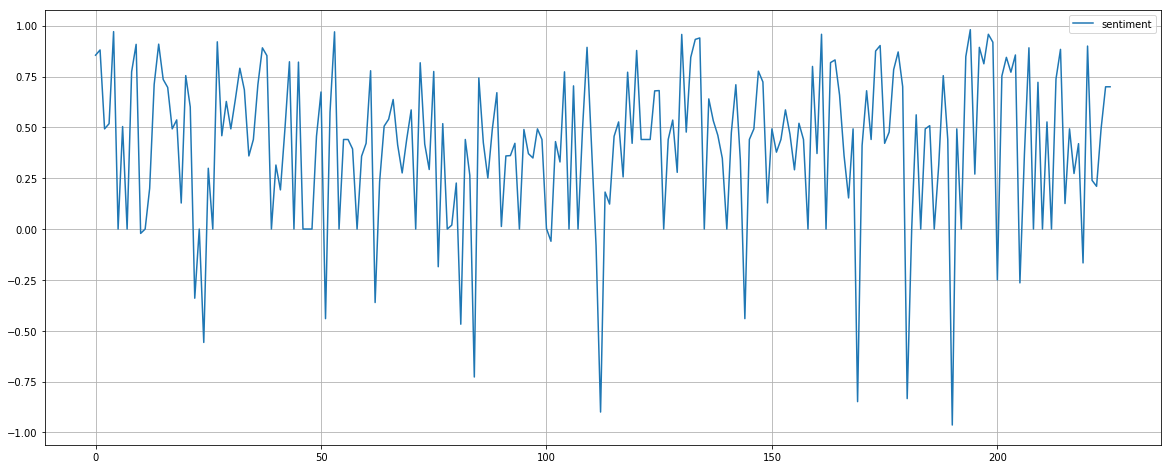

In [20]:
userSent = userSentScores(sample_data)
userSent.reset_index(inplace=True)
userSent.plot(x=userSent.index, y='sentiment', kind='line', figsize=(20,8), grid=True)

The user sentimentality is plotted by the index as using the posterId or poster name would crowd out the x axis ticks. It would be best to identify the x value on the graph of any interesting users, then using that on the userSent dataframe to find the user. 

### Planned Improvements:
- Find a method to utilize upvotes and downvotes on comments as a sentimentality score multiplier of a sort.
- Tidy up the graphs to make them more visually appealing.
- Examine if there are any relationships between a user's VIP status and user sentiment score (and possibly other features such as date commented, number of user's comments). 
- Use third-party novel review data to train a model for computing a sentiment score specific for the context of translated fiction. 